# Hog

In [1]:
from skimage.feature import hog
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as Image
import cv2
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline

In [2]:
vehical = 'data/vehicles/KITTI_extracted/'
non_vehical = 'data/non-vehicles/Extras/'

In [3]:
# 1: vehical 0: non_vehical
dict_label = {}
for name in os.listdir(vehical):
    file = os.path.join(vehical, name)
    dict_label[file] = 1

for name in os.listdir(non_vehical):
    file = os.path.join(non_vehical, name)
    dict_label[file] = 0

# sample a vehical

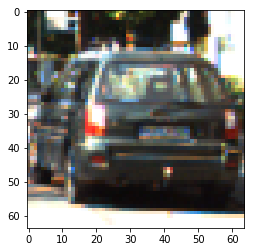

In [6]:
img_name = list(dict_label.keys())[np.random.randint(len(dict_label))]
img = cv2.imread(img_name)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Different color space and parameters

In [7]:
# convert color space
HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
LUV = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
YUV = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
YCrCb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

In [8]:
@interact(img_c = ['RGB', 'HSV', 'HLS', 'YUV', 'YCrCb','LUV'], orientations=(9,36,2), pix_per_cell=(2,30,1), cell_per_block=(2,10,1))
def hog_show(img_c = "RGB", orientations=9, pix_per_cell=8, cell_per_block=2):
    
    def hog_image(img):
        features, hog_image = hog(img, orientations=orientations,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          visualise=True, feature_vector=False,
                          block_norm="L2-Hys")
        return hog_image
    
    img_temp = None
    if img_c == "RGB":
        img_temp = img
    elif img_c == "HSV":
        img_temp = HSV
    elif img_c == "HLS":
        img_temp = HLS
    elif img_c == "YUV":
        img_temp = YUV
    elif img_c == "LUV":
        img_temp = LUV
    elif img_c == "YCrCb":
        img_temp = YCrCb
    
    f, ax = plt.subplots(2, 3 ,figsize=(12,8))
    for c in range(3):
        ax[0,c].imshow(img_temp[:, :, c], cmap=gray')
        ax[0,c].set_title(img_c[c])
        ax[1,c].imshow(hog_image(img_temp[:, :, c]), cmap='gray')
    plt.show()

# extract feature

In [20]:
def hog_extract(img, img_c = "YUV", orientations=9, pix_per_cell=8, cell_per_block=2， ravel=False):
    
    def hog_img(img_):
        features = hog(img_, orientations=orientations,
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block), 
                      visualise=False, feature_vector=ravel,
                      block_norm="L2-Hys")
        return features
    
    img_temp = None
    if img_c == "RGB":
        img_temp = img
    elif img_c == "HSV":
        img_temp = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    elif img_c == "HLS":
        img_temp = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif img_c == "YUV":
        img_temp = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif img_c == "LUV":
        img_temp = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    elif img_c == "YCrCb":
        img_temp = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    
    res = []
    for i in range(3):
        res.append(hog_img(img_temp[:, :, i]))
    
    return np.concatenate(res)

In [59]:
def color_extract(img, nbins=32):
    c1 = np.histogram(img[:, :, 0], bins=nbins)
    c2 = np.histogram(img[:, :, 1], bins=nbins)
    c3 = np.histogram(img[:, :, 2], bins=nbins)
    
    return np.concatenate([c1[0], c2[0], c3[0]])

In [46]:
def bin_spatial(img, size=(32,32)):
    c1 = cv2.resize(img[:, :, 0], size).ravel()
    c2 = cv2.resize(img[:, :, 1], size).ravel()
    c3 = cv2.resize(img[:, :, 2], size).ravel()
    return np.hstack([c1, c2, c3])

In [47]:
def extract_data(f, dict_label):
    X = []
    y = []
    for file in dict_label.keys():
        if not 'png' in file:
            continue
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        X.append(f(img))
        y.append(dict_label[file])
    X = np.stack(X)
    y = np.array(y)
    return (X, y)

# train a classifier

In [ ]:
'''
base score:
- hog: 0.89
- color: 0.97
- bin_spatial: 0.94
'''

In [40]:
from sklearn.tree import DecisionTreeClassifier

In [66]:
X,y = extract_data(bin_spatial, dict_label)

In [67]:
clf = DecisionTreeClassifier()
clf.fit(X[:10**4], y[:10**4])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [68]:
y_p = clf.predict(X[10**4:])
y_true = y[10**4:]

In [69]:
np.mean(y_p==y_true)

0.94294003868471954